# **Hi to all! This is my quick start notebook.**

# Hmm, the result of this notebook on the public dataset is interesting.... 0.540 is a lot, considering the failure of the model on the validation set, we will improve the model

# version 2 and 3 - Added cross validation

# version 4 - Added LGBM from this notebook https://www.kaggle.com/code/davidjlochner/base-tfidf-lgbm

# versions 5-8 - I tried changing the ngram parameter, but ngram=(1,1) seems to work best

# version 9 - Used autogluon to build the model

# version 12 - Make custom scorer fot the autogluon - This only worsened the result

# version 14-16 - Added cross validation 

# version 17 - Used new preprocessing from this great notebook https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments

# version 21 - Used new model from this great notebook https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments, which works much better

# version 23 - I will try to use GaussianNB to transform the results of the regression model into class labels

# version 25 - Restored the previous version because the idea didn't work

Choose the appropriate version of autogluon to train on GPU or CPU

In [1]:
#!pip install -q --no-index --find-links=/kaggle/input/autogluon-cpu autogluon
#!pip install -q --no-index --find-links=/kaggle/input/autogluon-gpu autogluon

In [2]:
# Importing necessary libraries
import gc
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
#from autogluon.tabular.models import NNFastAiTabularModel
#from autogluon.tabular import TabularDataset, TabularPredictor
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl

nltk.download('wordnet')

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
# 载入训练集和测试集，同时对full_text数据使用\n\n字符分割为列表，重命名为paragraph
# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)
# 显示训练集中的第一个样本数据
# Display the first sample data in the training set
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


In [4]:
# Importing the ProfileReport class from the ydata_profiling library
#from ydata_profiling import ProfileReport

# Generating a profile report for the train dataset
# Setting the title of the report to "Pandas Profiling Report"
#profile = ProfileReport(train, title="Pandas Profiling Report")

# Displaying the generated profile report
#profile

**A quick analysis showed that the class distribution resembles a normal distribution, interestingly….**


**Let's try to build a simple base model so we have something to go off of.
I will use a bag-of-words model with the addition of feature selection, which can simplify the classification model.**


# **Preprocessing**

## Features engineering - https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments

In [5]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    # 将单词转化为小写
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    # 移除html
    x = removeHTML(x)
    # 删除以@作为首字母的字符串
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # 删除数字
    # Delete Numbers
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    # 删除网址
    # Delete URL
    x = re.sub("http\w+", '',x)
    # 将连续空白符替换为一个空格字符
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # 替换连续的句号和逗号为一个
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # 去除开头结尾的空白符
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x

### 2.Paragraph Features

In [6]:
# 段落特征
# paragraph features
def Paragraph_Preprocess(tmp):
    # 将段落列表扩展为一行行的数据
    # Expand the paragraph list into several lines of data
    tmp = tmp.explode('paragraph')
    # 段落预处理
    # Paragraph preprocessing
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    # 计算每一个段落的长度
    # Calculate the length of each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    # 计算每一个段落中句子的数量和单词的数量
    # Calculate the number of sentences and words in each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
def Paragraph_Eng(train_tmp):
    aggs = [
        # 统计段落长度大于和小于 i 值的个数
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # 其他
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
# 获取特征名称
# Obtain feature names
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4


### 3.Sentence Features

In [7]:
# sentence feature
def Sentence_Preprocess(tmp):
    # 对full_text预处理，并且使用句号分割出文本的句子
    # Preprocess full_text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    # 计算句子的长度
    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    # 筛选出句子长度大于15的那一部分数据
    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    # 统计每一句中单词的数量
    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp
# feature_eng
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        # 统计句子长度大于 i 的句子个数
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        # 其他
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
# 将新生成的特征数据和之前生成的特征数据合并
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


### 4.Word Features

In [8]:
# word feature
def Word_Preprocess(tmp):
    # 对full_text预处理，并且使用空格符分割出文本的单词
    # Preprocess full_text and use spaces to separate words from the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    # 计算每一个的单词长度
    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    # 删除单词长度为0的数据
    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp
# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        # 统计单词长度大于 i+1 的单词个数
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # 其他
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
# 将新生成的特征数据和之前生成的特征数据合并
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


### 5.Tf-idf features

In [9]:
# TfidfVectorizer parameter
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(1,4),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)
# 将全部数据集都填充进TfidfVectorizer里，这可能会造成泄露和过于乐观的CV分数
# Fit all datasets into TfidfVector,this may cause leakage and overly optimistic CV scores
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
# 转换为数组
# Convert to array
dense_matrix = train_tfid.toarray()
# 转换为dataframe
# Convert to dataframe
df = pd.DataFrame(dense_matrix)
# 重命名特征
# rename features
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
# 将新生成的特征数据和之前生成的特征数据合并
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  8741


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_8662,tfid_8663,tfid_8664,tfid_8665,tfid_8666,tfid_8667,tfid_8668,tfid_8669,tfid_8670,tfid_8671
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.023801,0.048692,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


# **Model training**

In [10]:
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092


In [11]:
# Converting the 'text' column to string type and assigning to X
X = train_feats[feature_names].astype(np.float32).values

# Converting the 'score' column to integer type and assigning to y
y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a

In [12]:
X, Xtest, y, Ytest, y_split, y_split_test = train_test_split(X, y, y_split, test_size=0.2)

# **Let's use cross-validation**

In [13]:
X.shape, y.shape, y_split.shape

((13845, 8741), (13845,), (13845,))

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.746462	valid's QWK: 0.739934
[50]	train's QWK: 0.791024	valid's QWK: 0.77687
[75]	train's QWK: 0.810923	valid's QWK: 0.787989
[100]	train's QWK: 0.823766	valid's QWK: 0.794171
[125]	train's QWK: 0.833337	valid's QWK: 0.797643
[150]	train's QWK: 0.841119	valid's QWK: 0.799408
[175]	train's QWK: 0.849564	valid's QWK: 0.800047
[200]	train's QWK: 0.855578	valid's QWK: 0.799896
[225]	train's QWK: 0.862937	valid's QWK: 0.801278
[250]	train's QWK: 0.869625	valid's QWK: 0.802017
[275]	train's QWK: 0.874198	valid's QWK: 0.803333
[300]	train's QWK: 0.878799	valid's QWK: 0.805284
[325]	train's QWK: 0.885313	valid's QWK: 0.805674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	train's QWK: 0.889035	valid's QWK: 0.803885
[375]	train's QWK: 0.893074	valid's QWK: 0.806008
[400]	train's QWK: 0.898439	valid's QWK: 0.805787
[Ligh

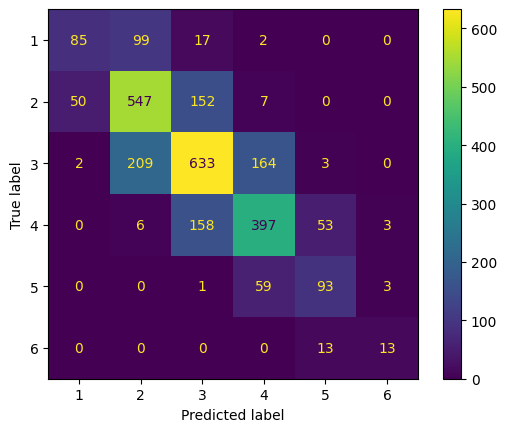

F1 score across fold: 0.6361409481654028
Cohen kappa score across fold: 0.8073396386750806
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.751737	valid's QWK: 0.721518
[50]	train's QWK: 0.794752	valid's QWK: 0.757007
[75]	train's QWK: 0.814951	valid's QWK: 0.773426
[100]	train's QWK: 0.826921	valid's QWK: 0.780627
[125]	train's QWK: 0.834857	valid's QWK: 0.785855
[150]	train's QWK: 0.842243	valid's QWK: 0.790128
[175]	train's QWK: 0.849366	valid's QWK: 0.793399
[200]	train's QWK: 0.855946	valid's QWK: 0.792795
[225]	train's QWK: 0.861495	valid's QWK: 0.793518
[250]	train's QWK: 0.867864	valid's QWK: 0.796258
[275]	train's QWK: 0.873485	valid's QWK: 0.796731
[300]	train's QWK: 0.878601	valid's QWK: 0.798
[325]	train's QWK: 0.883298	valid's QWK: 0.798865
[350]	train's QWK: 0.887705	valid's QWK: 0.79879
[375]	train's QWK: 0.892682	valid's QWK: 0.797023
[400]	train's QWK: 0.896393	valid's QWK: 0

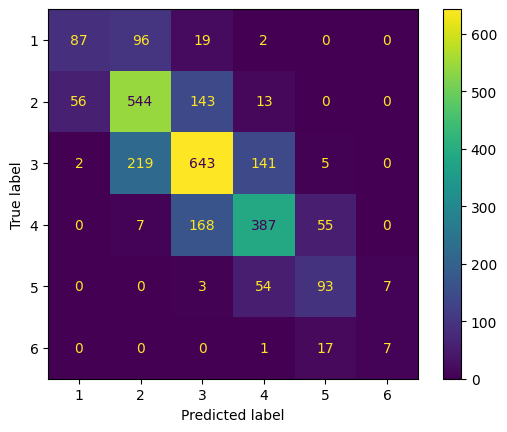

F1 score across fold: 0.6334965803082019
Cohen kappa score across fold: 0.8000652179314625
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.742778	valid's QWK: 0.741473
[50]	train's QWK: 0.790816	valid's QWK: 0.777876
[75]	train's QWK: 0.80951	valid's QWK: 0.792459
[100]	train's QWK: 0.821027	valid's QWK: 0.799857
[125]	train's QWK: 0.830691	valid's QWK: 0.802536
[150]	train's QWK: 0.841377	valid's QWK: 0.801763
[175]	train's QWK: 0.849441	valid's QWK: 0.804061
[200]	train's QWK: 0.856117	valid's QWK: 0.804284
[225]	train's QWK: 0.862695	valid's QWK: 0.806048
[250]	train's QWK: 0.868836	valid's QWK: 0.80627
[275]	train's QWK: 0.87503	valid's QWK: 0.807303
[300]	train's QWK: 0.879525	valid's QWK: 0.809719
[325]	train's QWK: 0.883751	valid's QWK: 0.809105
[350]	train's QWK: 0.888649	valid's QWK: 0.808453
[375]	train's QWK: 0.892726	valid's QWK: 0.809919
Early stopping, best iteration is:
[311]	

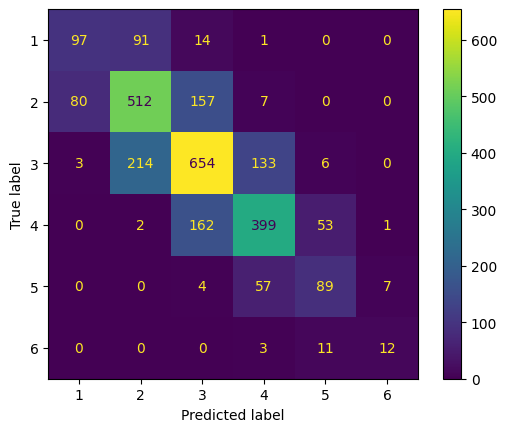

F1 score across fold: 0.6360167670907078
Cohen kappa score across fold: 0.8103611588623576
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.746485	valid's QWK: 0.752979
[50]	train's QWK: 0.792431	valid's QWK: 0.784114
[75]	train's QWK: 0.809723	valid's QWK: 0.794763
[100]	train's QWK: 0.822024	valid's QWK: 0.802456
[125]	train's QWK: 0.832336	valid's QWK: 0.805886
[150]	train's QWK: 0.841377	valid's QWK: 0.806313
[175]	train's QWK: 0.848946	valid's QWK: 0.809452
[200]	train's QWK: 0.854828	valid's QWK: 0.809896
[225]	train's QWK: 0.861441	valid's QWK: 0.811587
[250]	train's QWK: 0.867646	valid's QWK: 0.811156
[275]	train's QWK: 0.873623	valid's QWK: 0.810893
[300]	train's QWK: 0.877585	valid's QWK: 0.808664
Early stopping, best iteration is:
[229]	train's QWK: 0.862083	valid's QWK: 0.812857
Evaluated only: QWK


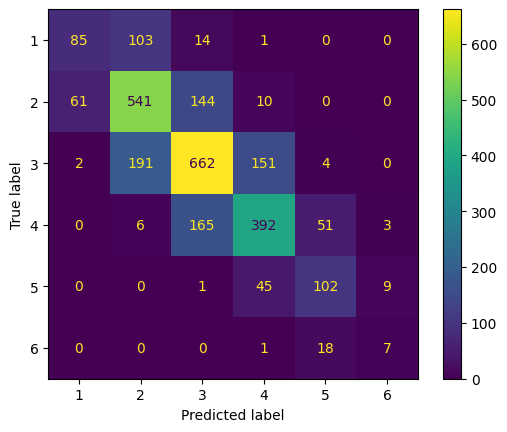

F1 score across fold: 0.64374103348809
Cohen kappa score across fold: 0.8128569089990296
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.746444	valid's QWK: 0.719652
[50]	train's QWK: 0.7945	valid's QWK: 0.760987
[75]	train's QWK: 0.814537	valid's QWK: 0.771828
[100]	train's QWK: 0.826279	valid's QWK: 0.780848
[125]	train's QWK: 0.837065	valid's QWK: 0.786217
[150]	train's QWK: 0.844613	valid's QWK: 0.787541
[175]	train's QWK: 0.851554	valid's QWK: 0.787616
[200]	train's QWK: 0.858306	valid's QWK: 0.7895
[225]	train's QWK: 0.863395	valid's QWK: 0.789642
[250]	train's QWK: 0.868786	valid's QWK: 0.788668
[275]	train's QWK: 0.873963	valid's QWK: 0.788722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's QWK: 0.878541	valid's QWK: 0.789455
Early stopping, best iteration is:
[230]	train's QWK: 0.86486	valid's QWK: 0.791093
Evaluated only: QWK


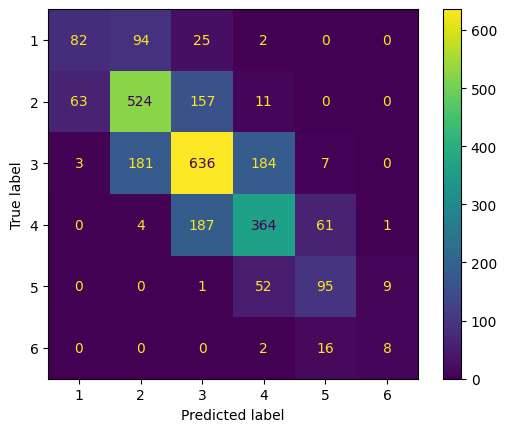

F1 score across fold: 0.6150621322279418
Cohen kappa score across fold: 0.7910934723954466
Mean F1 score across 5 folds: 0.6328914922560689
Mean Cohen kappa score across 5 folds: 0.8043432793726752


In [14]:
# Define the number of splits for cross-validation
n_splits = 5

# Initialize StratifiedKFold with the specified number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Lists to store scores
f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
# Loop through each fold of the cross-validation
i=1
for train_index, test_index in skf.split(X, y_split):
    # Split the data into training and testing sets for this fold
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
        
                verbosity = - 1)

    # Fit the model on the training data for this fold
    
    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    # Make predictions on the test data for this fold
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    # Calculate and store the F1 score for this fold
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    # Calculate and store the Cohen's kappa score for this fold
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    # Displaying the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1
# Calculate the mean scores across all folds
mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

In [15]:
import torch
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import accuracy_score
device = 'GPU' if torch.cuda.is_available() else 'CPU'
print(f"Running on {device}")
oof=[]
cat_models=[]
val_errs = []
accs=[]
n_splits = 5
i=1
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
for train_index, test_index in skf.split(X, y_split):
    Xtrain, Xval = X[train_index], X[test_index]
    Ytrain, Yval = y_split[train_index], y_split[test_index]
    cat_model = CatBoostRegressor(task_type=device, loss_function="RMSE")
    train_pool = Pool(data=Xtrain, label = Ytrain)
    valid_pool = Pool(data = Xval, label = Yval)
    print('\nFold_{} Training ================================\n'.format(i))
    cat_model.fit(train_pool,
                 verbose=100,
                 eval_set=valid_pool)
    pred_val = cat_model.predict(Xtest)
    oof.append(pred_val)
    err = cohen_kappa_score(y_split_test, pred_val.clip(1, 6).round(), weights='quadratic')
    acc = accuracy_score(y_split_test, pred_val.clip(1, 6).round())
    print(f"Kappa score : {err}\nAccuracy score : {acc}")
    val_errs.append(err)
    accs.append(acc)
    cat_models.append(cat_model)
    i+=1
    del Xtrain, Ytrain, Xval, Yval, train_pool, valid_pool
    gc.collect()

Running on GPU

Fold_1 Training ================================

Learning rate set to 0.08052
0:	learn: 1.0059745	test: 1.0052547	best: 1.0052547 (0)	total: 18.9s	remaining: 5h 15m 17s
100:	learn: 0.5688723	test: 0.5958526	best: 0.5958526 (100)	total: 56.8s	remaining: 8m 25s
200:	learn: 0.5228004	test: 0.5774909	best: 0.5774909 (200)	total: 1m 33s	remaining: 6m 11s
300:	learn: 0.4938577	test: 0.5708894	best: 0.5708894 (300)	total: 2m 9s	remaining: 5m 1s
400:	learn: 0.4708734	test: 0.5684470	best: 0.5684470 (400)	total: 2m 45s	remaining: 4m 7s
500:	learn: 0.4516864	test: 0.5664808	best: 0.5664282 (498)	total: 3m 21s	remaining: 3m 20s
600:	learn: 0.4333453	test: 0.5649508	best: 0.5648917 (592)	total: 3m 57s	remaining: 2m 37s
700:	learn: 0.4182868	test: 0.5645653	best: 0.5644360 (668)	total: 4m 32s	remaining: 1m 56s
800:	learn: 0.4034526	test: 0.5629155	best: 0.5629155 (800)	total: 5m 8s	remaining: 1m 16s
900:	learn: 0.3906139	test: 0.5625299	best: 0.5624622 (894)	total: 5m 43s	remaining

# **Inference**

In [16]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
# Tfidf
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')
# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

Features number:  8741


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_8662,tfid_8663,tfid_8664,tfid_8665,tfid_8666,tfid_8667,tfid_8668,tfid_8669,tfid_8670,tfid_8671
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.023801,0.048692,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [17]:
Xsub = test_feats[feature_names].values

In [18]:
probabilities = []
for model in models:
    proba= model.predict(test_feats[feature_names])+ a
    probabilities.append(proba)
# Compute the average probabilities across all models
predictions = np.mean(probabilities, axis=0)



# Print the predictions
print(predictions)


[2.00335044 2.86441543 4.44708621]


In [19]:
preds = []
for model in cat_models:
    pred = model.predict(Xsub)
    preds.append(pred)
    
cat_pred = np.mean(preds, axis=0).reshape(len(Xsub))


print(cat_pred)

[2.08549759 2.96308009 4.37505551]


In [20]:
final_pred = (cat_pred+predictions)/2
print(final_pred)
final_pred = np.round(final_pred.clip(1, 6))
print(final_pred)

[2.04442401 2.91374776 4.41107086]
[2. 3. 4.]


In [21]:
#test_vector=new_pipeline.transform(test['text'])
#predictions=lgb_model.predict(test_vector)
#predictions

In [22]:
#predictions = model.predict(test['text'])
#predictions
# Initialize an empty list to store probabilities for each model
"""
probabilities = []

# Iterate over each model in the list of models
for model in models:
    # Make predictions using the current model
    print(model.predict(test['text']))
    
    # Compute decision scores for the current model
    decision_scores = model.decision_function(test['text'])
    
    # Convert decision scores to probabilities using the sigmoid function
    proba = 1 / (1 + np.exp(-decision_scores))
    # Append the probabilities to the list
    probabilities.append(proba)

# Compute the average probabilities across all models
probabilities = np.mean(probabilities, axis=0)

# Determine the predicted class by selecting the class with the highest probability
# Add 1 to the index to match the class labels (assuming classes start from 1)
predictions = np.argmax(probabilities, axis=1) + 1

# Print the predictions
print(predictions)
"""

"\nprobabilities = []\n\n# Iterate over each model in the list of models\nfor model in models:\n    # Make predictions using the current model\n    print(model.predict(test['text']))\n    \n    # Compute decision scores for the current model\n    decision_scores = model.decision_function(test['text'])\n    \n    # Convert decision scores to probabilities using the sigmoid function\n    proba = 1 / (1 + np.exp(-decision_scores))\n    # Append the probabilities to the list\n    probabilities.append(proba)\n\n# Compute the average probabilities across all models\nprobabilities = np.mean(probabilities, axis=0)\n\n# Determine the predicted class by selecting the class with the highest probability\n# Add 1 to the index to match the class labels (assuming classes start from 1)\npredictions = np.argmax(probabilities, axis=1) + 1\n\n# Print the predictions\nprint(predictions)\n"

In [23]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=final_pred
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
